# Model evaluation and optimization for text classification


## Outline

* [Metrics for model evaluation](#metrics)
* [Load and inspect dataset](#dataset)
    * [Import modules](#import)
    * [Read and inspect data](#dataset)
    * [Preprocess data](#preprocess)
    * [Vectorization](#vectorize)
    * [Divide data into training and test sets](#split)
* [More classification with supervised machine learning](#supervised)
    * [Train decision tree model](#model)
    * [More model evaluation](#evaluate)
    * [Cross-validation](#cv)
    * [Optimize parameters with grid search](#gridsearch)
    * [Train and optimize Random Forest model](#RF)

# Data preparation<a id='preparation'></a>

## Import modules<a id='import'></a>

In [3]:
from itertools import product

In [28]:
f = lambda x,y: -(x-3)**2 - (y-2)**2

xspace = np.linspace(0,5,101)
yspace = np.linspace(0,5,101)
params = product(xspace,yspace)
# pp = list( params )
df = pd.DataFrame(params,columns=["x","y"])

In [30]:
df["fxy"] = df.apply(lambda r: f(r.x, r.y), axis=1)

<Axes: xlabel='y', ylabel='x'>

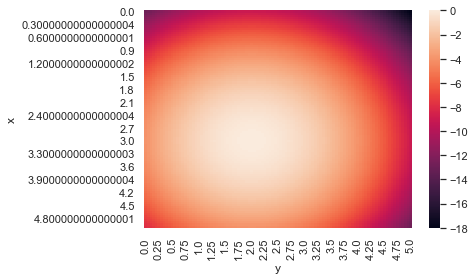

In [31]:
data= pd.pivot_table(df, values='fxy', index='x', columns='y')
sns.heatmap(data, 
#             annot=True
           )

In [2]:
import os
import re
import numpy as np
import pandas as pd
import warnings
import graphviz
from graphviz import Source
from sklearn.tree import export_graphviz
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

#set options
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()
%matplotlib inline

#scikit-learn is a huge library. We import what we need.
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, train_test_split #sklearn utilities
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #For model evaluation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #Vectorizers
from sklearn.linear_model import LogisticRegressionCV #Logit with cross-validation
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #Random Forest and AdaBoost classifiers
from sklearn.tree import DecisionTreeClassifier #Decision Tree classifier
from sklearn.svm import LinearSVC #Linear Support Vector classifier

## Read and inspect dataset<a id='dataset'></a>

In [3]:
df = pd.read_csv('../../public_data/crowdflower_tweets.csv')
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


<Axes: xlabel='airline', ylabel='count'>

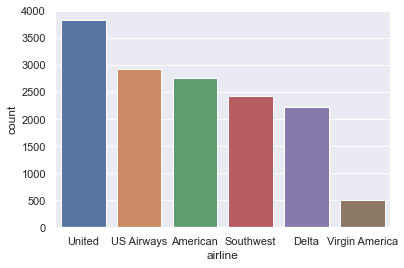

In [4]:
# plt.figure(figsize=(20,10))
sns.countplot(df['airline'], order=df['airline'].value_counts().index)


Let's get to know the data:

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- What are the main reasons why people are tweeting negatively? 

To visualize counts, this time let's use the `sns.countplot()` function. To visualize proportions, use the `.plot(kind='bar')` method.

In [8]:
print("Length is", len(df))

df['airline_sentiment'].value_counts()

Length is 14640


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [5]:
df['airline_sentiment'].value_counts(normalize=True)

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: proportion, dtype: float64

<Axes: xlabel='airline_sentiment'>

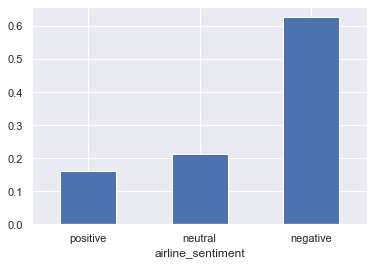

In [6]:
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0)

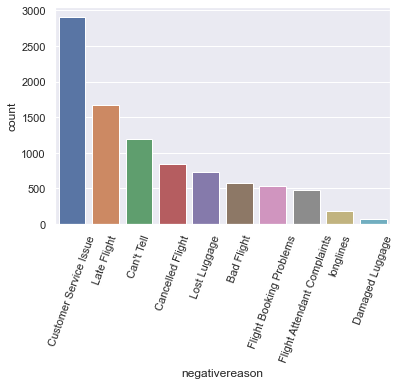

In [29]:
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
plt.xticks(rotation=70);

## Preprocess data<a id='preprocess'></a>

In [5]:
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'

def clean_tweet(tweet):
    tweet = re.sub(hashtag_pattern, ' HASHTAG', tweet) 
    tweet = re.sub(twitter_handle_pattern, 'USER', tweet)
    return re.sub(url_pattern, 'URL', tweet)

# apply function to DF 
df['clean_text'] = (df['text'].apply(clean_tweet))

## Vectorization<a id='vectorization'></a>

In [6]:
countvectorizer = CountVectorizer(max_features=5000, binary=True)
X = countvectorizer.fit_transform(df['clean_text'])
features = X.toarray() # convert matrix to sparse format for easy modeling
response = df['airline_sentiment'].values # corresponds to entries in `features` 
feature_names = countvectorizer.get_feature_names_out() # get feature names for later
label_names = list(set(response)) # get label names for later

## Divide data into training and test sets<a id='split'></a>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, stratify = df.airline_sentiment)

X_train.shape, X_test.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

# More classification with supervised machine learning<a id='supervised'></a>

## Train decision tree model<a id='model'></a>

In [8]:
dt_classifier = DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                                       splitter='best',  # or 'random' for random best split
                                       max_depth=10,  # how deep tree nodes can go
                                       min_samples_split=5,  # samples needed to split node
                                       min_samples_leaf=10,  # samples needed for a leaf
                                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                       max_features=None,  # number of features to look for when splitting
                                       max_leaf_nodes=None,  # max nodes
                                       min_impurity_decrease=1e-07, #early stopping
                                       random_state = 10) #random seed

dt_classifier.fit(X_train, y_train) # fit model on training set

DecisionTreeClassifier(max_depth=10, min_impurity_decrease=1e-07,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=10)

In [14]:
from sklearn import tree

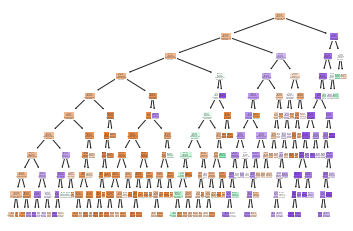

In [15]:
tree.plot_tree(dt_classifier, 
                   feature_names=feature_names,  
                   class_names=label_names,
                   filled=True, )
print("")

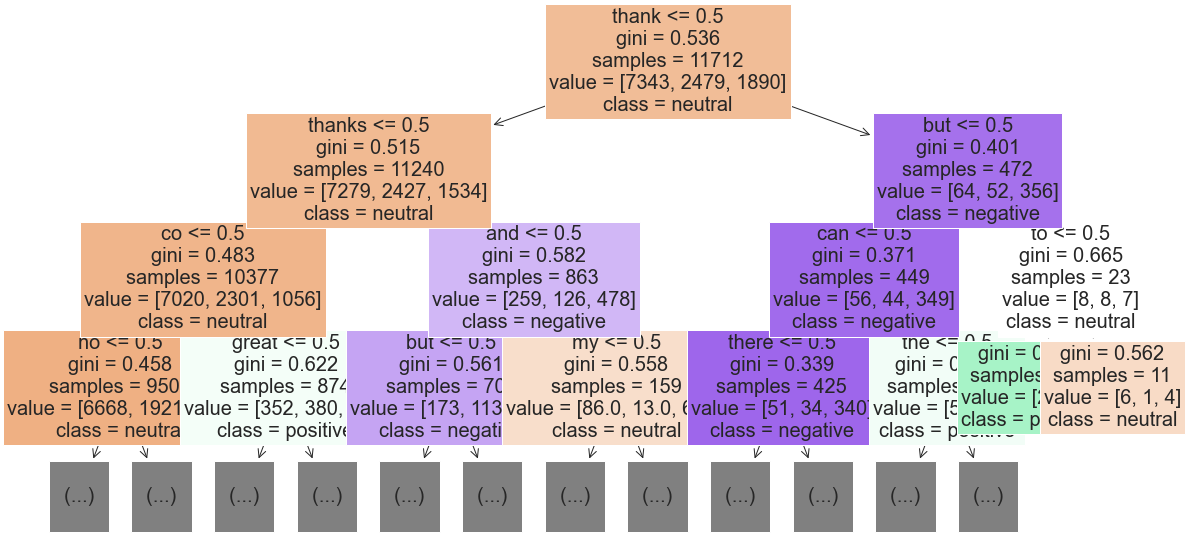

In [16]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt_classifier, 
                   feature_names=feature_names,  
                   class_names=label_names,
                   filled=True, max_depth=3,fontsize=20,
      )
print("")

In [17]:
#predict the labels on the test set using the trained model
predictions_dt = dt_classifier.predict(X_test) 

accuracy_score(predictions_dt, y_test)

0.7062841530054644

In [18]:
# We can also use the built-in `model.score()` method instead this time, results are same as for `accuracy_score()`
print(dt_classifier.score(X_test, y_test))

0.7062841530054644


### IN-CLASS CHALLENGE 1: Predict labels on unseen data

Use the Decisition Tree model you just built to predict the label for three unlabeled reviews. Predict both the label and the probability of being in each category. Do the predictions make sense? Do the probabilities provide any useful information beyond the predicted labels?

_Hint:_ Remember to use `countvectorizer()` and convert to sparse format with `.toarray()` to vectorize the texts prior to prediction. Use `model.predict()` to predict the class and `model.predict_proba()` to predict class probabilities.

In [9]:
careless_review = "I made my flight reservation with UnitedAirlines and the service is ridiculous and they just bluntly \
deny solving your problem. I booked my flight but they were having some technical issues and didn't appear \
in their system. United customer service just said they can not do anything and asked me to book a new ticket to fly. \
This is just insane and troubling and also really costly at the airport. Thus, I made my flight reservation \
with United Airlines for the next day through an online flight booking portal that offered much cheaper flights. \
You can contact them over the phone by calling a toll-free number +1-888-720-1433 and book flights that are light \
on your pocket."

good_review = "United was very accommodating for our vacation recently and even got us home a little quicker. \
We were travelling in a group of 12 coming home from a vacation and because of storms back east our connecting flight \
was delayed by hours. Knowing this was completely out of their control we started talking with one of the United \
employees and told them where we were headed. She said she could get us on a flight that actually leaves earlier \
than our original flight. It was such great service and resulted in all of us getting home hours later. The only \
issue was our bags, but United had them delivered to our homes that next morning."

canceled_review = "Canceled my trip twice, the first time I received no notification. The second time I got a notice \
that one of my trips may have been canceled or changed, the website didn’t say which it was. It instructed me to cancel \
it myself. Probably so they could avoid having to refund me. Now I all the money I spent on tickets sitting in a United \
account but I never want to fly with them in the future so that’s a nice chunk of about $2000 wasted. \
EDIT: After I cancelled my second trip I was able to select an option for refund, the refund was not only \
for the second trip but also my first trip that was cancelled earlier. I will upgrade the rating from 1 to 3 stars \
would have given higher with better customer service/website service/website information."

In [32]:
# solution
# Transform these into DTMs with the same feature-columns as previously
unknown_dtm = countvectorizer.transform(
    [careless_review, good_review, canceled_review]).toarray()

# Use model to predict the class for these three. Predict class
print("Predicted classes:")
print(dt_classifier.predict(unknown_dtm))
print()
print(f"Predicted probabilities for each review\n(order: {dt_classifier.classes_}):")
print(dt_classifier.predict_proba(unknown_dtm)) # Predict probability of membership in each category

Predicted classes:
['negative' 'negative' 'negative']

Predicted probabilities for each review
(order: ['negative' 'neutral' 'positive']):
[[0.73333333 0.13333333 0.13333333]
 [0.58823529 0.         0.41176471]
 [0.5        0.4        0.1       ]]


In [30]:
# solution
# Transform these into DTMs with the same feature-columns as previously
unknown_dtm = countvectorizer.transform([careless_review, good_review, canceled_review]).toarray()

# Use model to predict the class for these three. Predict class
print("Predicted classes:")
print(dt_classifier.predict(unknown_dtm))
print()
print(f"Predicted probabilities for each review\n(order: {dt_classifier.classes_}):")
print(dt_classifier.predict_proba(unknown_dtm)) # Predict probability of membership in each category

Predicted classes:
['negative' 'negative' 'negative']

Predicted probabilities for each review
(order: ['negative' 'neutral' 'positive']):
[[0.73333333 0.13333333 0.13333333]
 [0.58823529 0.         0.41176471]
 [0.5        0.4        0.1       ]]


In [12]:
countvectorizer

CountVectorizer(binary=True, max_features=5000)

## Cross-validation<a id='cv'></a>

In [13]:
scores = cross_val_score(dt_classifier, X_train, y_train, cv=3)
scores   

array([0.69877049, 0.69006148, 0.6880123 ])

In [14]:
# Show average accuracy across folds along with sigma (std. squared)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.6923 (+/- 0.0093)


## More model evaluation <a id="evaluate"></a>

Text(0.5, 12.453125, 'Prediction')

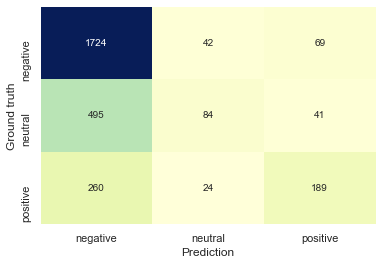

In [18]:
model = dt_classifier # change this one line to visualize confusion matrix for other models
y_predict = model.predict(X_test) 
labels = model.classes_
conmat = confusion_matrix(y_test, y_predict)

sns.heatmap(conmat, 
            annot=True, 
            fmt='d', 
            xticklabels=labels, 
            yticklabels=labels, 
            cmap="YlGnBu", 
            cbar=False)
plt.ylabel('Ground truth')
plt.xlabel('Prediction')

In [19]:
dt_predicted = dt_classifier.predict(X_test)
print("Classification report:")
print(classification_report(y_test, dt_predicted)) 

Classification report:
              precision    recall  f1-score   support

    negative       0.70      0.94      0.80      1835
     neutral       0.56      0.14      0.22       620
    positive       0.63      0.40      0.49       473

    accuracy                           0.68      2928
   macro avg       0.63      0.49      0.50      2928
weighted avg       0.66      0.68      0.63      2928



## Optimize parameters with grid search <a id="gridsearch"></a>

In [15]:
# Grid searching is computationally expensive, so for time's sake we'll test a minimal range for each parameter
# In real-world data analytics there would be a much larger range, making exponentially more permutations (and time cost)

param_grid = {'min_samples_split': [5,10], # define dictionary with possible model parameters
              'min_samples_leaf': [10,20]}

param_grid

{'min_samples_split': [5, 10], 'min_samples_leaf': [10, 20]}

In [16]:
# Warning: This can take a long time!
model_dt = GridSearchCV(DecisionTreeClassifier(max_depth=10, 
                                               criterion='gini',  # or 'entropy' for information gain
                                               splitter='best',  # or 'random' for random best split
                                               min_impurity_decrease=1e-07, #early stopping 
                                               random_state = 10), #random seed
                        param_grid, 
                        cv=3, 
                        return_train_score=True)

model_dt.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=10,
                                              min_impurity_decrease=1e-07,
                                              random_state=10),
             param_grid={'min_samples_leaf': [10, 20],
                         'min_samples_split': [5, 10]},
             return_train_score=True)

In [17]:
# Get information on model parameters that perform best
model = model_dt # Change this to visualize other models

# Get index of best model parameters
best_index = np.argmax(
    model.cv_results_["mean_train_score"]
                      )

print('Best parameter values are:', 
      model.cv_results_["params"][best_index]
     )
print('Best mean cross-validation train accuracy: %.03f' % 
      model.cv_results_["mean_train_score"][best_index]
     )
print('Overall mean test accuracy: %.03f' % 
      model.score(X_test, y_test)
     )

Best parameter values are: {'min_samples_leaf': 10, 'min_samples_split': 5}
Best mean cross-validation train accuracy: 0.709
Overall mean test accuracy: 0.686


## Train and optimize Random Forest model <a id="RF"></a>

In [24]:
rf_classifier = RandomForestClassifier(n_estimators=10,  # number of trees
                       criterion='gini',  # or 'entropy' for information gain
                       max_depth=10,  # how deep tree nodes can go
                    )  

rf_model = rf_classifier.fit(X_train, y_train) # fit model on training data

In [25]:
print("Accuracy of Random Forest model (with 3-fold CV) with test data defined above:")
scores = cross_val_score(rf_model, X_test, y_test, cv=3)
print("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) # Show average accuracy across folds
print()

predicted = rf_model.predict(X_test)
print("Classification report:")
print(classification_report(y_test, predicted)) 
print()

Accuracy of Random Forest model (with 3-fold CV) with test data defined above:
0.6332 (+/- 0.0077)

Classification report:
              precision    recall  f1-score   support

    negative       0.63      1.00      0.78      1835
     neutral       0.90      0.04      0.08       620
    positive       1.00      0.01      0.02       473

    accuracy                           0.64      2928
   macro avg       0.84      0.35      0.29      2928
weighted avg       0.75      0.64      0.51      2928




### IN-CLASS CHALLENGE 2: Grid Search on Random Forest

Do another grid search to determine the best parameters for the Random Forest we just created. Use two possible levels for `min_samples_split` and `min_samples_leaf`, each between 5 and 20. 

In [31]:
# solution
param_grid = {'min_samples_split': [5,20],
              'min_samples_leaf': [5,20]}

rf_model = GridSearchCV(RandomForestClassifier(), # adjusts weights inverse of freq with subsampling
                        param_grid, 
                        cv=3, 
                        return_train_score=True)

rf_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [21]:
# # solution
param_grid = {'min_samples_split': [5,20],
              'min_samples_leaf': [5,20]}

rf_model = GridSearchCV(RandomForestClassifier(n_estimators=10, 
                                               max_depth=10,  # how deep tree nodes can go
                                               min_impurity_decrease=1e-07,  # early stopping
                                               random_state = 10,  # random seed
                                               class_weight="balanced_subsample"), # adjusts weights inverse of freq with subsampling
                        param_grid, 
                        cv=3, 
                        return_train_score=True)

rf_model.fit(X_train, y_train)

In [ ]:
rf_model.cv_results_["mean_train_score"]

In [ ]:
best_index = np.argmax(rf_model.cv_results_["mean_train_score"])

print("Best parameter values:", rf_model.cv_results_["params"][best_index])
print("Best mean cross-validated training accuracy:", rf_model.cv_results_["mean_train_score"][best_index])
print("Best model test accuracy:", rf_model.score(X_test, y_test))

### IN-CLASS CHALLENGE 3: Adjust text preprocessing

Preprocessing methods matter for machine learning performance: Depending on the algorithm, less or more preprocessing may be better. Let's see how a simple Random Forest model does with minimal preprocessing--without removing usernames, hashtags, or URLs. Compare this model's performance with that of Random Forest trained on cleaned text.

In [33]:
# solution
# Vectorize texts
countvec_dirty = CountVectorizer(max_features=5000, binary=True)
features_dirty = countvec_dirty.fit_transform(df['text']).toarray() # convert matrix to sparse format for easy modeling
response_dirty = df['airline_sentiment'].values # corresponds to entries in `features` 

X_train_dirty, X_test_dirty, y_train_dirty, y_test_dirty = train_test_split(features_dirty, 
                                                                            response_dirty, test_size=0.2)
X_train_dirty.shape, X_test_dirty.shape #look at number of rows and columns in training and test data

((11712, 5000), (2928, 5000))

In [34]:
rf_dirty = RandomForestClassifier(n_estimators=10,  # number of trees
                                  min_impurity_decrease=1e-07,  # early stopping
                                  random_state = 10,  # random seed
                                  class_weight="balanced")  # adjusts weights inverse of freq

rf_dirty = rf_dirty.fit(X_train_dirty, y_train_dirty)

In [35]:
scores = cross_val_score(rf_dirty, X_train_dirty, y_train_dirty, cv=3)
print("Mean cross-validation train accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2)) # Show average accuracy across folds
print("Overall mean test accuracy:", rf_dirty.score(X_test_dirty, y_test_dirty))

Mean cross-validation train accuracy: 0.7351 (+/- 0.0189)
Overall mean test accuracy: 0.7476092896174863


Random Forest with text preprocessing gave a mean accuracy of just over 0.61, so removing text preprocessing improves model accuracy by about **13 percent**! 